In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import colorsys
import json
from json import JSONEncoder
from rembg import remove
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATADIR = 'dataset-resized/'
CATEGORIES = ['plastic','trash']

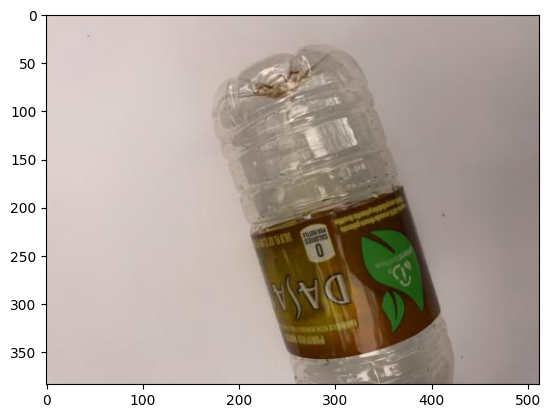

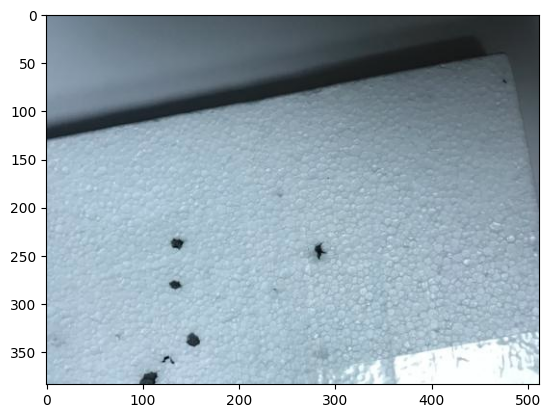

In [3]:
for category in CATEGORIES:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        split_tup = os.path.splitext(img)
        if len(split_tup) > 1 and split_tup[len(split_tup)-1] == ".jpg":
            img_array=cv2.imread(os.path.join(path,img),cv2.COLOR_BGR2RGB)
            plt.imshow(img_array)
            plt.show()
            break
    #break

In [4]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = remove(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

def extract_features(path, img, split_tup):
    image_path = os.path.join(path, img)
    json_file = split_tup[0] + ".json"
    json_path = os.path.join(path, json_file)
    if os.path.exists(json_path):
        # Opening JSON file
        f = open(json_path)
        json_details = json.load(f)
        hsl_color_values = json_details["hsl_color_values"]
        has_high_hsl = False
        for hsl in hsl_color_values:
            if hsl[1] > 0.5:
                has_high_hsl = True
                
        if has_high_hsl and split_tup[0].startswith("plastic"):
            return hsl_color_values
        else:
            if not has_high_hsl:
                return hsl_color_values
            else:
                return []
    else:
        image = get_image(image_path)
        number_of_colors = 10
        modified_image = image.reshape(image.shape[0]*image.shape[1], 3)
        nobg_image = remove(modified_image)
        clf = KMeans(n_clusters = number_of_colors)
        labels = clf.fit_predict(modified_image)
        
        counts = Counter(labels)

        center_colors = clf.cluster_centers_

        # We get ordered colors by iterating through the keys
        ordered_colors = [center_colors[i] for i in counts.keys()]
        hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
        rgb_colors = [ordered_colors[i] for i in counts.keys()]
        hsl_color_values = []

        for i in range(len(rgb_colors)):
            rgb_color = rgb_colors[i]
            hsl_color_val = colorsys.rgb_to_hsv(rgb_color[0],rgb_color[1],rgb_color[2])
            hsl_color_values.append(hsl_color_val)

        
        json_details = {"rgb_colors": rgb_colors,
                        "hex_colors": hex_colors,
                        "hsl_color_values": hsl_color_values}
        # Serializing json
        json_object = json.dumps(json_details, indent=4, cls=NumpyArrayEncoder)
 
        # Writing to sample.json
        with open(json_path, "w") as outfile:
            outfile.write(json_object)

        return hsl_color_values

plastic 0 0
trash 0 1


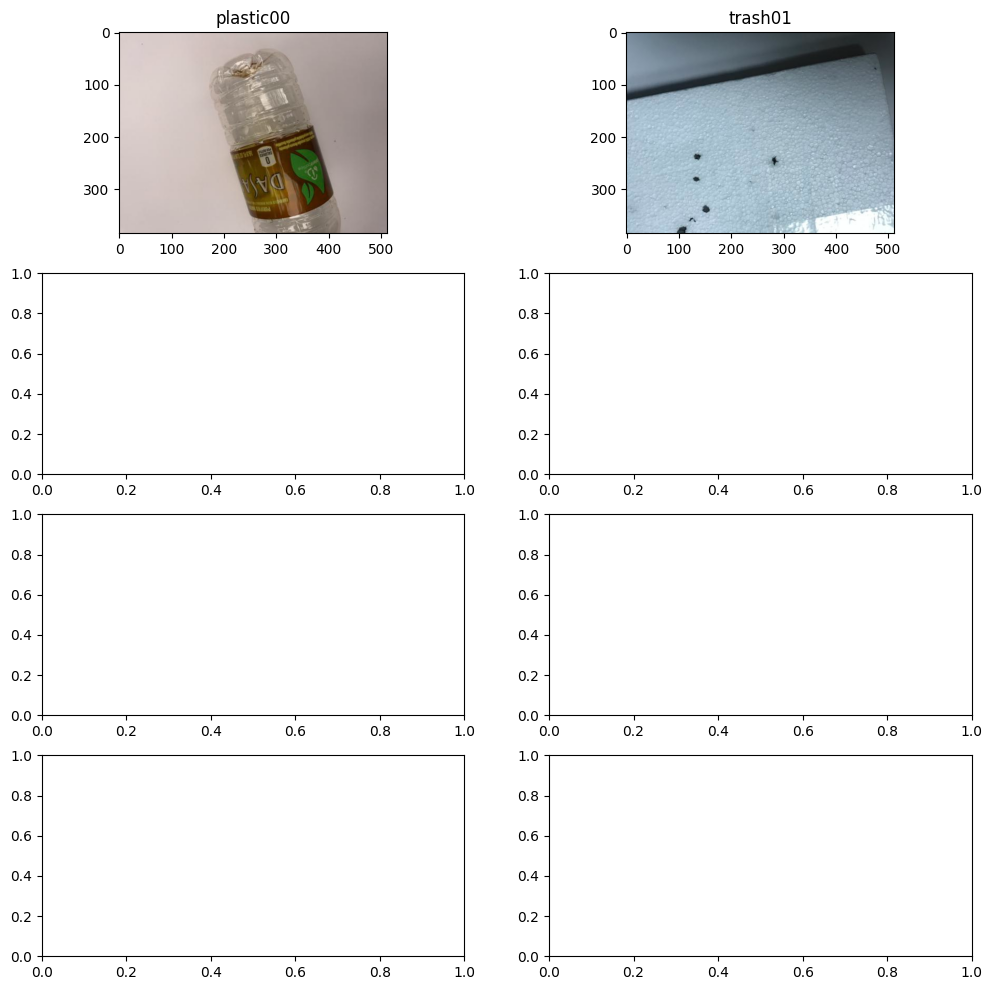

In [5]:
cols=2
rows=4
col_index=0
row_index=0
f, axarr = plt.subplots(rows,cols,figsize=(12, 12))
for category in CATEGORIES:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        split_tup = os.path.splitext(img)
        if len(split_tup) > 1 and split_tup[len(split_tup)-1] == ".jpg":
            img_array=cv2.imread(os.path.join(path,img),cv2.COLOR_BGR2RGB)
            axarr[row_index,col_index].imshow(img_array)
            axarr[row_index,col_index].set_title(category+str(row_index)+str(col_index))
            print(category,row_index,col_index)
            break
    col_index=col_index+1
    if(col_index==cols):
        row_index=row_index+1
        col_index=0

In [6]:
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            split_tup = os.path.splitext(img)
            if len(split_tup) > 1 and split_tup[len(split_tup)-1] == ".jpg":
                try:
                    features = extract_features(path, img, split_tup)
                    if len(features) > 0:
                        training_data.append([features,class_num])
                except Exception as e:
                    print(e)
                    pass
                
create_training_data()  

In [7]:
lenofimage = len(training_data)

In [8]:
X=[]
y=[]

for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= numpy.array(X).reshape(lenofimage,-1)

# numpy.isnan(X.any()) #and gets False

#index = 0
#for i in X[:,0]:
#    if not numpy.isfinite(i):
#        print(index, i)
#    index +=1

numpy.isfinite(X.all()) #and gets True


# X = tf.keras.utils.normalize(X, axis = 1)

True

In [9]:
X.shape

(529, 30)

In [10]:
X=X/255

In [11]:
X[1]

array([3.55199907e-04, 1.04663851e-03, 4.32342912e-04, 3.82419010e-04,
       8.11586593e-04, 7.32936073e-01, 3.75028739e-04, 7.43315133e-04,
       8.18373243e-01, 4.39032526e-04, 1.21468698e-03, 4.10325945e-01,
       4.34306928e-04, 1.01485681e-03, 5.28687673e-01, 3.71720745e-04,
       9.60011429e-04, 1.61631154e-01, 4.07070787e-04, 9.33187883e-04,
       5.90435800e-01, 4.40544597e-04, 1.09022758e-03, 4.72284501e-01,
       4.30220583e-04, 1.27832085e-03, 3.34351367e-01, 3.98272784e-04,
       9.05728228e-04, 6.59709307e-01])

In [12]:
y=numpy.array(y)

In [13]:
y.shape

(529,)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [15]:
from sklearn.svm import SVC
svc = SVC(kernel='linear',gamma='auto')
svc.fit(X_train, y_train)

pickle.dump(svc, open("color_svm.sav", 'wb'))

In [16]:
y2 = svc.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test,y2))

Accuracy on unknown data is 0.9172932330827067


In [18]:
from sklearn.metrics import classification_report
print("Accuracy on unknown data is",classification_report(y_test,y2))

Accuracy on unknown data is               precision    recall  f1-score   support

           0       0.92      1.00      0.96       122
           1       0.00      0.00      0.00        11

    accuracy                           0.92       133
   macro avg       0.46      0.50      0.48       133
weighted avg       0.84      0.92      0.88       133



In [19]:
result = pd.DataFrame({'original' : y_test,'predicted' : y2})
result

,original,predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
128,0,0
129,0,0
130,0,0
131,0,0
